In [2]:
from collections import defaultdict
import os

import keras
from keras.models import Model
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

import core
from core.cam import overlay_gradcam
from core.fine_model import FineModel
import cr_interface as cri
from cr_interface import CrCollection

from sklearn.manifold import TSNE

ImportError: cannot import name 'imresize' from 'scipy.misc' (/Users/itsnamgyu/code/cardiac-research/venv/lib/python3.7/site-packages/scipy/misc/__init__.py)

In [ ]:
CACHE_DIR = os.path.join(os.getcwd(), 'cache')
os.makedirs(CACHE_DIR, exist_ok=True)

In [ ]:
MODEL_LABELS = {
    'vgg16': 'VGG16',
    'mobilenet_a25': 'MobileNetV1(alpha=0.25)',
    'mobilenet_v2_a35': 'MobileNetV2(alpha=0.35)',
    'resnet50_v2': 'ResNet50V2',
    'inception_v3': 'InceptionV3',
    'inception_resnet_v2': 'InceptionResNetV2',
    'densenet_121': 'DenseNet121',
    'nasnet_mobile': 'NASNetMobile',
    'xception': 'Xception',
}

In [5]:
def get_partial_model(fm: FineModel):
    """Get model that outputs pooled features
    """
    def _get_penultimate_layer_index(model):
        for index, layer in enumerate(model.layers):
            if isinstance(layer, keras.layers.pooling.GlobalAveragePooling2D):
                return index
        raise AssertionError("model should have a GlobalAveragePooling2D layer")
    layer_index = _get_penultimate_layer_index(fm.model)
    return Model(inputs=fm.model.input, outputs=fm.model.layers[layer_index].output)

In [6]:
def get_classifier(fm: FineModel):
    """Get model that takes pooled features and outputs predictions
    """
    def _get_penultimate_layer_index(model):
        for index, layer in enumerate(model.layers):
            if isinstance(layer, keras.layers.pooling.GlobalAveragePooling2D):
                return index
        raise AssertionError("model should have a GlobalAveragePooling2D layer")
    layer_index = _get_penultimate_layer_index(fm.model)
    input_size = fm.model.layers[layer_index + 1].input_shape[1:]
    input_layer = keras.layers.Input(input_size)
    model = input_layer
    for layer in fm.model.layers[layer_index + 1:]:
        model = layer(model)
    return Model(inputs=input_layer, outputs=model)

## Load data, model, results

In [7]:
model_key = "vgg16"
test_model = FineModel.get_dict()[model_key]()
test_model.load_weights("D00_FINAL")

Loading model vgg16... complete!
Loading weights from /Users/itsnamgyu/code/cardiac-research/experiments/deep_a0/output/vgg16/D00_FINAL/trained_weights.hd5...
Weights loaded


## Load test data

In [9]:
LABEL_INDICES = {
    'in': 0,
    'oap': 1,
    'obs': 2,
}
dataset = CrCollection.load().filter_by(dataset_index=1).tri_label().labeled()
dataset.df["label_index"] = dataset.df.label.map(lambda l: LABEL_INDICES[l])
dataset.df = dataset.df.sort_values(["label_index", "cr_code"])
print(len(dataset.df))
dataset.df = dataset.df.reset_index(drop=True)
dataset.df.head()

2516


,cr_code,dataset_index,pid,phase_index,slice_index,label,original_name,original_filepath,label_index
0,D01_P00000301_P00_S03,1,301,0,3,in,DET0000301_SA4_ph0,cap_challenge_validation/Validation/CAP_challe...,0
1,D01_P00000301_P00_S04,1,301,0,4,in,DET0000301_SA5_ph0,cap_challenge_validation/Validation/CAP_challe...,0
2,D01_P00000301_P00_S05,1,301,0,5,in,DET0000301_SA6_ph0,cap_challenge_validation/Validation/CAP_challe...,0
3,D01_P00000301_P00_S06,1,301,0,6,in,DET0000301_SA7_ph0,cap_challenge_validation/Validation/CAP_challe...,0
4,D01_P00000301_P00_S07,1,301,0,7,in,DET0000301_SA8_ph0,cap_challenge_validation/Validation/CAP_challe...,0


## Generate Pooled Output

In [81]:
partial = get_partial_model(test_model)
generator = test_model.get_test_generator(dataset=dataset, shuffle=False, batch_size=4)
generator.reset()
outputs = partial.predict_generator(generator, steps=len(generator), verbose=1)

--------------------Loading image generator for test dataset--------------------
Found 2516 images belonging to 3 classes.
629/629 [==============================] - 768s 1s/step


In [166]:
outputs.shape

(2516, 512)

## Cache Outputs

In [10]:
def get_output_cache_path(model_key):
    return os.path.join(CACHE_DIR, 'pooled_output_{}.npy'.format(model_key))

In [168]:
np.save(get_output_cache_path(model_key), outputs)

In [169]:
outputs = np.load(get_output_cache_path(model_key))

In [170]:
outputs.shape

(2516, 512)

## Validate Outputs

In [18]:
def label_to_vector(label_index):
    vector = [0, 0, 0]
    vector[label_index] = 1
    return vector
label_vector = np.stack(list(map(label_to_vector, dataset.df.label_index)))

In [173]:
classifier = get_classifier(test_model)
classifier.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
accuracy = classifier.evaluate(outputs, label_vector)[1]
print(accuracy)
assert(accuracy > 0.5)

2516/2516 [==============================] - 4s 1ms/step
0.859697933322106


## Extract tSNE

In [ ]:
raw = TSNE(n_components=2, random_state=0).fit_transform(outputs)

In [ ]:
raw.shape

In [ ]:
raw2 = raw

In [ ]:
raw1 

## Plot tSNE

In [12]:
def get_tsne_figure(raw, model_key):
    embeddings = pd.DataFrame(raw)
    embeddings.columns = ['x', 'y']
    embeddings['label_index'] = dataset.df.label_index
    
    fig = mpl.figure.Figure(figsize=(8, 6), constrained_layout=True)
    ax = fig.subplots()
    scatter = ax.scatter(embeddings.x, embeddings.y, c=embeddings.label_index, cmap='viridis', alpha=0.8)
    legend1 = ax.legend(scatter.legend_elements()[0],
                        ['IN', 'OAP', 'OBS'],
                        title="Ground Truth")
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])
    fig_title = 'tSNE Analysis of {} Features'.format(MODEL_LABELS[model_key])
    fig.suptitle(fig_title, fontweight='bold', fontsize=14)
    
    return fig

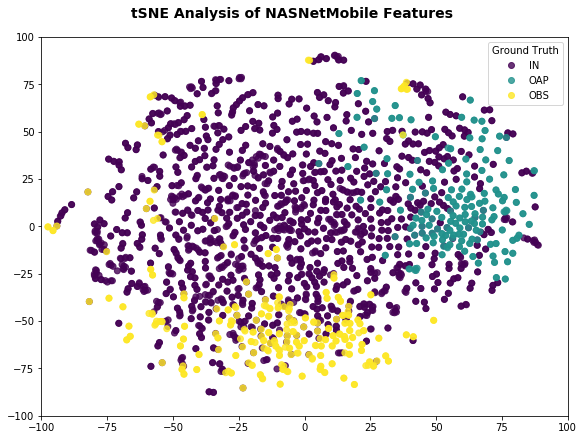

In [182]:
fig = get_tsne_figure(raw, model_key)
fig

In [183]:
fig.savefig('tSNE_{}.png'.format(model_key), dpi=320, bbox_inches='tight')

## Functional

In [18]:
def label_to_vector(label_index):
    vector = [0, 0, 0]
    vector[label_index] = 1
    return vector
label_vector = np.stack(list(map(label_to_vector, dataset.df.label_index)))

In [19]:
LABEL_INDICES = {
    'oap': 0,
    'obs': 1,
    'in': 2,
}

def analyze_tsne(model_key):
    dataset = CrCollection.load().filter_by(dataset_index=1).tri_label().labeled()
    
    try:
        outputs = np.load(get_output_cache_path(model_key))
        print('Using cached pooled features')
    except FileNotFoundError:
        test_model = FineModel.get_dict()[model_key]()
        test_model.load_weights("D00_FINAL")
        partial = get_partial_model(test_model)
        generator = test_model.get_test_generator(dataset=dataset, shuffle=False, batch_size=4)
        generator.reset()
        outputs = partial.predict_generator(generator, steps=len(generator), verbose=1)

        # Validate outputs
        classifier = get_classifier(test_model)
        classifier.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
        accuracy = classifier.evaluate(outputs, label_vector)[1]
        print('Prediction accuracy: {}'.format(accuracy))
        assert(accuracy > 0.5)
        
        np.save(get_output_cache_path(model_key), outputs)
        outputs = np.load(get_output_cache_path(model_key))
    
    raw = TSNE(n_components=2, random_state=0).fit_transform(outputs)
    figure = get_tsne_figure(raw, model_key)
    figure.savefig('tSNE_{}.png'.format(model_key), dpi=320, bbox_inches='tight')

In [20]:
#for model_key in ['vgg16', 'mobilenet_v2_a35', 'mobilenet_a25', 'nasnet_mobile']:
for model_key in ['nasnet_mobile']:
    print(" Analyzing tSNE for {} ".format(model_key).center(80, '#'))
    analyze_tsne(model_key)

####################### Analyzing tSNE for nasnet_mobile #######################
Loading model nasnet_mobile... complete!
Loading weights from /Users/itsnamgyu/code/cardiac-research/experiments/deep_a0/output/nasnet_mobile/D00_FINAL/trained_weights.hd5...
Weights loaded
--------------------Loading image generator for test dataset--------------------
Found 2516 images belonging to 3 classes.
2516/2516 [==============================] - 5s 2ms/step
Prediction accuracy: 0.6999205087440381
